In [1]:
module EulerSystem2D

export ConservativeVariables, EigensystemX, EigenvaluesX,
   EigensystemY, EigenvaluesY, MaximumEigenvalue, Pressure

# function Pressure(Q :: Transpose{Float64,Array{Float64,1}}, γ)
#    return (γ-1)*(Q[3] - Q[2].^2 ./ Q[1]/2)
# end
#
function Pressure(Q :: Array{Float64,1}, γ)
   return (γ-1)*(Q[4] - (Q[2].^2+Q[3].^2) ./ Q[1]/2)
end

function Pressure(Q :: Array{Float64,2}, γ)
   return (γ-1)*(Q[:,4] - (Q[:,2].^2+Q[:,3].^2) ./ Q[:,1]/2)
end

function Pressure(Q :: Array{Float64,3}, γ)
   return (γ-1)*(Q[:,:,4] - (Q[:,:,2].^2+Q[:,:,3].^2) ./ Q[:,:,1]/2)
end

function ConservativeVariables(Q, γ)
   return ConservativeVariables(Q[:,:,1], Q[:,:,2], Q[:,:,3], Q[:,:,4], γ)
end

function ConservativeVariables(ρ, u, v, p, γ)
   ρu = ρ.*u
   ρv = ρ.*v
   E = p/(γ-1) + ρ.*(u.^2+v.^2)/2
   return [ρ;;; ρu;;; ρv;;; E]
end

function PrimitiveVariables(Q :: Array{Float64,1}, γ)
   R = Q[1]
   U = Q[2]/R
   V = Q[3]/R
   P = Pressure(Q, γ)
   return R, U, V, P
end

function PrimitiveVariables(Q :: Array{Float64,2}, γ)
   R = Q[:,1]
   U = Q[:,2]./R
   V = Q[:,3]./R
   P = Pressure(Q, γ)
   return R, U, V, P
end

function PrimitiveVariables(Q :: Array{Float64,3}, γ)
   R = Q[:,:,1]
   U = Q[:,:,2]./R
   V = Q[:,:,3]./R
   P = Pressure(Q, γ)
   return R, U, V, P
end

function ArithmeticAverage(Q, γ)
   r = 3
   Qa = (Q[r,:] + Q[r+1,:])/2

   R, U, V, P = PrimitiveVariables(Qa, γ)
   A = sqrt.(γ*P/R)     # Sound speed
   H = (Qa[4] + P)/R    # Enthalpy
   h = 1/(2*H - U^2 - V^2)

   return U, V, A, H, h
end

function EigensystemX(Q, γ)
   Average = ArithmeticAverage
   #Average = RoeAverage

   U, V, A, H, h = Average(Q, γ)

   R = [1.0  U-A  V    H-U*A;
        1.0  U    V    (U^2+V^2)/2.0;
        0.0  0.0  1.0  V;
        1.0  U+A  V    H+U*A]

   I2A, Hh, Uh, Vh = 0.5/A, H*h, U*h, V*h

   L = [U*I2A+Hh-0.5  2.0-2.0*Hh  -V   Hh-0.5-U*I2A;
        -Uh-I2A       2.0*Uh      0.0  I2A-Uh;
        -Vh           2.0*Vh      1.0  -Vh;
        h             -2.0*h      0.0  h]

   return R, L
end

function EigenvaluesX(Q, γ)
   R, U, V, P = PrimitiveVariables(Q, γ)
   A = sqrt.(γ*P./R)

   return [U-A U U U+A]
end

function EigensystemY(Q, γ)
   Average = ArithmeticAverage
   #Average = RoeAverage

   U, V, A, H, h = Average(Q, γ)

   R = [1.0  U    V-A  H-V*A;
        1.0  U    V    (U^2+V^2)/2.0;
        0.0  1.0  0.0  U;
        1.0  U    V+A  H+V*A]

   I2A, Hh, Uh, Vh = 0.5/A, H*h, U*h, V*h

   L = [V*I2A+Hh-0.5  2.0-2.0*Hh  -U   Hh-0.5-V*I2A;
        -Uh           2.0*Uh      1.0  -Uh;
        -Vh-I2A       2.0*Vh      0.0  I2A-Vh;
        h             -2.0*h      0.0  h]

   return R, L
end

function EigenvaluesY(Q, γ)
   R, U, V, P = PrimitiveVariables(Q, γ)
   A = sqrt.(γ*P./R)

   return [V-A V V V+A]
end

function MaximumEigenvalue(Q, γ)
   R, U, V, P = PrimitiveVariables(Q, γ)
   A = sqrt.(γ*P./R)

   MU = max(maximum((U-A).^2), maximum((U+A).^2))
   MV = max(maximum((V-A).^2), maximum((V+A).^2))
   return sqrt(MU+MV)
end

end


Main.EulerSystem2D

In [2]:
using LinearAlgebra
using .EulerSystem2D

function Euler2D(Q, γ, Δx, Δy, CFL, FinalTime, Force, BoundaryConditionX,  BoundaryConditionY)
   Time = 0.0
   Δ = min(Δx, Δy)

   while Time < FinalTime
      Δt = CFL*Δ/MaximumEigenvalue(Q, γ)
      if Δt > (FinalTime - Time)
         Δt = FinalTime - Time
      end

      # 3rd order TVD Runge-Kutta scheme
      Q1 =      Q          -     Δt * (FluxDerivativeX(Q, γ, Δx, BoundaryConditionX)  + FluxDerivativeY(Q, γ, Δy, BoundaryConditionY)  .- Force(Q))
      Q2 = (3.0*Q +     Q1 -     Δt * (FluxDerivativeX(Q1, γ, Δx, BoundaryConditionX) + FluxDerivativeY(Q1, γ, Δy, BoundaryConditionY) .- Force(Q1))) / 4.0
      Q  = (    Q + 2.0*Q2 - 2.0*Δt * (FluxDerivativeX(Q2, γ, Δx, BoundaryConditionX) + FluxDerivativeY(Q2, γ, Δy, BoundaryConditionY) .- Force(Q2))) / 3.0

      Time  = Time + Δt;
   end
   return Q
end

function FluxDerivativeX(Q, γ, Δx, BoundaryConditionX)
   Ord = 5 # The order of the scheme
   N = size(Q, 1)
   M = size(Q, 2)
   F_half = zeros(N+1, M, 4)
   G_half = zeros(1, 4)
   #Qi = zeros(Ord+1, 3)   # Não adianta pré-alocar assim

   QB = BoundaryConditionX(Q)
   #M = MaximumEigenvalue(QB, γ)

   for j = 1:M
      for i = 1:N+1
         Qi = QB[i:i+Ord, j, :]
         Λ = EigenvaluesX(Qi, γ)
         M = maximum(abs.(Λ))

         R, L = EigensystemX(Qi, γ)

         W = Qi*L       # Transforms into characteristic variables
         G = Λ.*W       # The flux for the characteristic variables is Λ * L*QB
         for k = 1:4    # WENO reconstruction of the flux G
            G_half[k] = ReconstructedFlux(G[:,k], W[:,k], M)
         end

         F_half[i,j,:] = G_half*R # Brings back to conservative variables
      end
   end

   return (F_half[2:end,:,:] - F_half[1:end-1,:,:]) / Δx # Derivative of Flux
end

function FluxDerivativeY(Q, γ, Δy, BoundaryConditionY)
   Ord = 5 # The order of the scheme
   N = size(Q, 1)
   M = size(Q, 2)
   F_half = zeros(N, M+1, 4)
   G_half = zeros(1, 4)
   #Qj = zeros(Ord+1, 3)   # Não adianta pré-alocar assim

   QB = BoundaryConditionY(Q)
   #M = MaximumEigenvalue(QB, γ)

   for j = 1:M+1
      for i = 1:N
         Qj = QB[i, j:j+Ord, :]
         Λ = EigenvaluesY(Qj, γ)
         M = maximum(abs.(Λ))

         R, L = EigensystemY(Qj, γ)

         W = Qj*L       # Transforms into characteristic variables
         G = Λ.*W       # The flux for the characteristic variables is Λ * L*QB
         for k = 1:4    # WENO reconstruction of the flux G
            G_half[k] = ReconstructedFlux(G[:,k], W[:,k], M)
         end

         F_half[i,j,:] = G_half*R # Brings back to conservative variables
      end
   end

   return (F_half[:,2:end,:] - F_half[:,1:end-1,:]) / Δy # Derivative of Flux
end

function ReconstructedFlux(F, Q, M)
   ReconstructionLTR = WenoZ5ReconstructionLTR
   #ReconstructionLTR = WenoM5ReconstructionLTR

   F_plus  = (F + M*Q)/2
   F_minus = (F - M*Q)/2

   F_half_plus  = ReconstructionLTR(F_plus)
   F_half_minus = ReconstructionLTR(F_minus[end:-1:1])

   return F_half_plus + F_half_minus
end

function WenoZ5ReconstructionLTR(Q)
   ɛ = 10.0^(-40)
   # Calcula os indicadores de suavidade locais
   β0 = (1/2*Q[1] - 2*Q[2] + 3/2*Q[3])^2 + 13/12*(Q[1] - 2*Q[2] + Q[3])^2
   β1 = (-1/2*Q[2] + 1/2*Q[4])^2 + 13/12*(Q[2] - 2*Q[3] + Q[4])^2
   β2 = (-3/2*Q[3] + 2*Q[4] - 1/2*Q[5])^2 + 13/12*(Q[3] - 2*Q[4] + Q[5])^2
   # Calcula o indicador de suavidade global
   τ = abs(β0 - β2)
   # Calcula os pesos do WENO-Z
   α0 = (1/10) * (1 + (τ/(β0 + ɛ))^2)
   α1 = (6/10) * (1 + (τ/(β1 + ɛ))^2)
   α2 = (3/10) * (1 + (τ/(β2 + ɛ))^2)
   sum_α = α0 + α1 + α2
   ω0 = α0 / sum_α
   ω1 = α1 / sum_α
   ω2 = α2 / sum_α
   # Calcula os fhat em cada subestêncil
   fhat0 = (2*Q[1] - 7*Q[2] + 11*Q[3])/6
   fhat1 = (-Q[2] + 5*Q[3] + 2*Q[4])/6
   fhat2 = (2*Q[3] + 5*Q[4] - Q[5])/6
   #Finalmente, calcula o fhat do estêncil todo
   return ω0*fhat0 + ω1*fhat1 + ω2*fhat2
end

g(ω, d) = (ω*(d+d^2-3*d*ω+ω^2))/(d^2+ω*(1-2*d))

function WenoM5ReconstructionLTR(Q)
   ɛ = 10.0^(-40)
   # Calcula os indicadores de suavidade locais
   β0 = (1/2*Q[1] - 2*Q[2] + 3/2*Q[3])^2 + 13/12*(Q[1] - 2*Q[2] + Q[3])^2
   β1 = (-1/2*Q[2] + 1/2*Q[4])^2 + 13/12*(Q[2] - 2*Q[3] + Q[4])^2
   β2 = (-3/2*Q[3] + 2*Q[4] - 1/2*Q[5])^2 + 13/12*(Q[3] - 2*Q[4] + Q[5])^2
   # Calcula os pesos do WENO-JS
   α0 = (1/10) * (1/(β0 + ɛ)^2)
   α1 = (6/10) * (1/(β1 + ɛ)^2)
   α2 = (3/10) * (1/(β2 + ɛ)^2)
   sum_α = α0 + α1 + α2
   ω0 = α0 / sum_α
   ω1 = α1 / sum_α
   ω2 = α2 / sum_α
   # Mapeia
   α0 = g(ω0, 1/10)
   α1 = g(ω1, 6/10)
   α2 = g(ω2, 3/10)
   sum_α = α0 + α1 + α2
   ω0 = α0 / sum_α
   ω1 = α1 / sum_α
   ω2 = α2 / sum_α
   # Calcula os fhat em cada subestêncil
   fhat0 = (2*Q[1] - 7*Q[2] + 11*Q[3])/6
   fhat1 = (-Q[2] + 5*Q[3] + 2*Q[4])/6
   fhat2 = (2*Q[3] + 5*Q[4] - Q[5])/6
   #Finalmente, calcula o fhat do estêncil todo
   return ω0*fhat0 + ω1*fhat1 + ω2*fhat2
end

function PeriodicGhostPointsX(Q)
   Qg = [Q[end-2:end,:,:]; Q; Q[1:3,:,:]]
end

function PeriodicGhostPointsY(Q)
   Qg = [Q[:,end-2:end,:] Q Q[:,1:3,:]]
end


PeriodicGhostPointsY (generic function with 1 method)

In [3]:
using Plots
plotly()

function MalhaRetangular(N)
   Δ = 1.0/N
   Δx = Δ; Δy = Δ
   x = 0.0:Δx:0.25
   y = Δy:Δy:1.0-Δy

   X = repeat(reshape(x, length(x), 1), 1, length(y))
   Y = repeat(reshape(y, 1, length(y)), length(x), 1)

   return X, Y, Δ
end

function CondiçãoInicialRayleighTaylor(X :: Array{Float64, 2}, Y :: Array{Float64, 2}, γ)
   R = zeros(size(X))
   P = zeros(size(X))
   U = zeros(size(X))
   V = zeros(size(X))
   for i = eachindex(R)
      if Y[i] < 0.5
         R[i] = 2.0
         P[i] = 2.0*Y[i] + 1.0
      else
         R[i] = 1.0
         P[i] = Y[i] + 1.5
      end
      a = √(γ * P[i] / R[i])
      V[i] = -0.025 * a * cos(8.0*π*X[i]);
   end

   E = P/(γ-1.0) + R.*(U.^2 + V.^2)/2.0

   #Q0 = cat(R, R.*U, R.*V, E, dims=3)
   Q0 = [R;;; R.*U;;; R.*V;;; E]
   return Q0
end

function CondiçãoInicialRayleighTaylor(N :: Int64, γ)
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialRayleighTaylor(X, Y, γ)
   return X, Y, Δ, Q0
end

function RayleighTaylorGravity(Q :: Array{Float64,3})
   g = -1.0
   # for i = 1:size(U,1)
   #    for j = 1:size(U,2)
   #       F[i,j,3] = -g * U[i,j,1]
   #       F[i,j,4] = -g * U[i,j,3]
   #    end
   # end
   Z = zeros(size(Q,1), size(Q,2), 1)
   F = [Z;;;Z;;;-g*Q[:,:,1];;;-g*Q[:,:,3]]
   return F
end

function RayleighTaylorGhostPointsX(Q)
   #c = [1.0,-1.0,1.0,1.0]
   # for i = 1:3; for k = 1:4; Ug[i,k] = c[k]*U[end-i,j,k]; end; end
   # for i = 4:size(Ug,1)-3; for k = 1:4; Ug[i,k] = U[i-3,j,k]; end; end
   # for i = -2:0; for k = 1:4; Ug[size(Ug,1)+i,k] = c[k]*U[1-i,j,k]; end; end
   Qg = [[Q[3:-1:1, :, 1];;;-Q[3:-1:1, :, 2];;;Q[3:-1:1, :, 3];;;Q[3:-1:1, :, 4]];
         Q;
         [Q[end:-1:end-2, :, 1];;;-Q[end:-1:end-2, :, 2];;;Q[end:-1:end-2, :, 3];;;Q[end:-1:end-2, :, 4]]]
   return Qg
end

function RayleighTaylorGhostPointsY(Q, γ)
   # for j = 1:3
   #    Ug[j,1] = 2.0
   #    Ug[j,2] = 0.0
   #    Ug[j,3] = 0.0
   #    Ug[j,4] = 1.0/(5.0/3.0 - 1.0)
   # end
   # for j = 4:size(Ug,1)-3; for k = 1:4; Ug[j,k] = U[i,j-3,k]; end; end
   # for j = -2:0
   #    Ug[size(Ug,1)+j,1] = 1.0
   #    Ug[size(Ug,1)+j,2] = 0.0
   #    Ug[size(Ug,1)+j,3] = 0.0
   #    Ug[size(Ug,1)+j,4] = 2.5/(5.0/3.0 - 1.0)
   # end
   M = size(Q,1)
   Qg = [repeat([2.0;;;0.0;;;0.0;;;1.0/(γ-1.0)], M, 3);;
         Q;;
         repeat([1.0;;;0.0;;;0.0;;;2.5/(γ-1.0)], M, 3)]
   return Qg
end

function grafico(x, y, U, título)
   x_list=zeros(size(x,1)*size(x,2))
   y_list=zeros(size(y,1)*size(y,2))
   z_list=zeros(size(x,1)*size(x,2))

   for i in 1:size(x,1)
      for j in 1:size(x,2)
         x_list[(i-1)*size(x,1)+j]=x[i,j]
         y_list[(i-1)*size(x,1)+j]=y[i,j]
         z_list[(i-1)*size(x,1)+j]=U[i,j,1]
      end
   end
   
   plot(
      heatmap(
         x=x_list,
         y=y_list,
         z=z_list,
     ),
     st = :heatmap, aspect_ratio = 0.75, title = título, size = (800,800))
end

function RayleighTaylor(N :: Integer)
   γ = 5.0/3.0
   #N = 160
   x, y, Δ, U0 = CondiçãoInicialRayleighTaylor(N, γ)
   cfl = 0.6
   t_final = 0.001
   GhostPointsX(U) = RayleighTaylorGhostPointsX(U)
   GhostPointsY(U) = RayleighTaylorGhostPointsY(U, γ)
   U = Euler2D(U0, γ, Δ, Δ, cfl, t_final, RayleighTaylorGravity, GhostPointsX, GhostPointsY)
   grafico(x, y, U, "T = $t_final")
end



(process:19864): GLib-GIO-WARNING **: 20:15:02.728: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.3.4.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs
┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots C:\Users\silva\.julia\packages\Plots\1KWPG\src\backends.jl:318


RayleighTaylor (generic function with 1 method)

In [4]:
using Plots
plotly()

function MalhaRetangular(N)
   Δ = 10.0/N
   Δx = Δ; Δy = Δ
   x = -5.0:Δx:5.0
   y = -1.0:Δy:1.0-Δy

   X = repeat(reshape(x, length(x), 1), 1, length(y))
   Y = repeat(reshape(y, 1, length(y)), length(x), 1)

   return X, Y, Δ
end

function CondiçãoInicialShockEntropy2D(X :: Array{Float64, 2}, Y :: Array{Float64, 2}, γ :: Float64, θ :: Float64)
   R = zeros(size(X))
   U = zeros(size(X))
   V = zeros(size(X))
   P = ones(size(X))

   I = ones(size(X))
   l = X .< -4.0
   r = X .>= -4.0

   R[l] = I[l] * 27.0/7.0
   U[l] = I[l] * 4.0*√(35.0)/9.0
   P[l] = I[l] * 31.0/3.0

   R[r] = 1.0 .+ sin.(X[r]*cos(θ)*2.0*π + Y[r]*sin(θ)*2.0*π)/5.0

   E = P/(γ-1.0) + R.*(U.^2 + V.^2)/2.0

   #Q0 = cat(R, R.*U, R.*V, E, dims=3)
   Q0 = [R;;; R.*U;;; R.*V;;; E]
   return Q0
end

function CondiçãoInicialShockEntropy2D(N :: Int64, γ :: Float64, θ :: Float64)
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialShockEntropy2D(X, Y, γ, θ)
   return X, Y, Δ, Q0
end

function NullForce(Q :: Array{Float64,3})
   return 0.0
end

function ShockEntropy2DGhostPointsX(Q, γ, Δx, y, θ)
   ρl, ul, pl = 27.0/7.0, 4.0*√(35.0)/9.0, 31.0/3.0
   El = pl/(γ-1.0) + ρl.*(ul.^2)/2.0
   Ql = repeat([ρl;;; ρl*ul;;; 0.0;;; El], 3, size(Q,2))

   Xr = repeat([5.0+Δx; 5.0+2*Δx; 5.0+3*Δx], 1, size(Q,2))
   Yr = y[1:3,:]
   ρr = 1.0 .+ sin.(5.0*Xr*cos(θ) + 5.0*Yr*sin(θ))/5.0
   pr = ones(size(ρr))
   ur = zeros(size(ρr))
   vr = zeros(size(ρr))
   Er = pr/(γ-1.0)
   Qr = [ρr;;; ur;;; vr;;; Er]

   Qg = [Ql; Q; Qr]
   return Qg
end

function ShockEntropy2DGhostPointsY(Q)
   Qg = [Q[:,end-2:end,:];;
         Q;;
         Q[:,1:3,:]]
   return Qg
end

function grafico(x, y, U, título)
   for k = 1:1
      gui(plot(x, y, U[:,:,k], st = :surface, aspect_ratio = 0.75, camera = (0,89.5), title = título * "$k", size = (800,800)))
   end
end

function ShockEntropy2D(N :: Integer)
   γ = 7.0/5.0
   θ = π/6.0
   #N = 160
   x, y, Δ, U0 = CondiçãoInicialShockEntropy2D(N, γ, θ)
   cfl = 0.5
   t_final = 0.01
   #grafico(x, y, U0, "Condição Inicial")
   GhostPointsX(U) = ShockEntropy2DGhostPointsX(U, γ, Δ, y, θ)
   GhostPointsY(U) = ShockEntropy2DGhostPointsY(U)
   U = Euler2D(U0, γ, Δ, Δ, cfl, 0.001, NullForce, GhostPointsX, GhostPointsY)
   U = Euler2D(U0, γ, Δ, Δ, cfl, t_final, NullForce, GhostPointsX, GhostPointsY)
   grafico(x, y, U, "T = $t_final")
   return nothing
end


ShockEntropy2D (generic function with 1 method)

In [5]:
γ = 7.0/5.0
θ = π/6.0
N = 100
x, y, Δ, U0 = CondiçãoInicialShockEntropy2D(N, γ, θ)
size(U0)

(101, 20, 4)

In [ ]:
U0= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_shock_entropy.h5", "r") do file
    permutedims(read(file, "U0"),[2,1,3])
end

In [8]:
function Pressure(Q :: Array{Float64,3}, γ)
    return (γ-1)*(Q[:,:,4] - (Q[:,:,2].^2+Q[:,:,3].^2) ./ Q[:,:,1]/2)
 end

LoadError: error in method definition: function EulerSystem2D.Pressure must be explicitly imported to be extended

In [10]:
using HDF5

function ShockEntropy2D(label,t_final,NullForce, GhostPointsX, GhostPointsY)
    U0= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_"*label*".h5", "r") do file
        permutedims(read(file, "U0"),[2,1,3])
    end
    γ= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_"*label*".h5", "r") do file
        read(file, "γ")
    end
    θ= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_"*label*".h5", "r") do file
        read(file, "θ")
    end
    x= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_"*label*".h5", "r") do file
        read(file, "x")
    end
    y= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_"*label*".h5", "r") do file
        read(file, "y")
    end
    Δ= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_"*label*".h5", "r") do file
        read(file, "Δ")
    end
    cfl= h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_init_"*label*".h5", "r") do file
        read(file, "cfl")
    end

    #Qt= Euler2D(U0, γ, Δ, Δ, cfl, t_final, NullForce, GhostPointsX, GhostPointsY)
    N = size(U0, 1)
    M = size(U0, 2)
    Ord=5
    QB= GhostPointsX(U0)
    Qi_X=zeros(N+1,M,6,4)
    Λ_X=zeros(N+1,M,6,4)
    X_l=zeros(N+1,M,4,4)
    X_r=zeros(N+1,M,4,4)
    for j = 1:M
        for i = 1:N+1
            Qi = QB[i:i+Ord, j, :]
            Λ = EigenvaluesX(Qi, γ)
            M = maximum(abs.(Λ))

            R, L = EigensystemX(Qi, γ)
            
            Qi_X[i,j,:,:]=Qi
            Λ_X[i,j,:,:]=Λ
            X_l[i,j,:,:]=L
            X_r[i,j,:,:]=R

        end
    end
    N = size(U0, 1)
    M = size(U0, 2)
    QB= GhostPointsY(U0)
    Qj_Y=zeros(N,M+1,6,4)
    Λ_Y=zeros(N,M+1,6,4)
    Y_l=zeros(N,M+1,4,4)
    Y_r=zeros(N,M+1,4,4)
    for j = 1:M+1
        for i = 1:N
           Qj = QB[i, j:j+Ord, :]
           Λ = EigenvaluesY(Qj, γ)
           M = maximum(abs.(Λ))
  
           R, L = EigensystemY(Qj, γ)

           Qj_Y[i,j,:,:]=Qj
           Λ_Y[i,j,:,:]=Λ
           Y_l[i,j,:,:]=L
           Y_r[i,j,:,:]=R

        end
    end
    h5open("C:\\Jupyter\\Edge detection\\WENO-DS\\data_full_"*label*".h5", "w") do file
        write(file, "Qi_X", Qi_X)
        write(file, "Qj_Y", Qj_Y)
        write(file, "Λ_X", Λ_X)
        write(file, "Λ_Y", Λ_Y)
        write(file, "X_l", X_l)
        write(file, "X_r", X_r)
        write(file, "Y_l", Y_l)
        write(file, "Y_r", Y_r)
        write(file, "P", Pressure(U0,γ))
    end
end

ShockEntropy2D (generic function with 2 methods)

In [11]:
GhostPointsX(U) = ShockEntropy2DGhostPointsX(U, γ, Δ, y, θ)
GhostPointsY(U) = ShockEntropy2DGhostPointsY(U)
ShockEntropy2D("shock_entropy",0.001,NullForce, GhostPointsX, GhostPointsY)

In [21]:
γ = 7.0/5.0
θ = π/6.0
N = 400
x, y, Δ, U0 = CondiçãoInicialShockEntropy2D(N, γ, θ)
cfl = 0.5
t_final = 0.001
GhostPointsX(U) = ShockEntropy2DGhostPointsX(U, γ, Δ, y, θ)
GhostPointsY(U) = ShockEntropy2DGhostPointsY(U)
U = Euler2D(U0, γ, Δ, Δ, cfl, 0.001, NullForce, GhostPointsX, GhostPointsY)
U = Euler2D(U0, γ, Δ, Δ, cfl, t_final, NullForce, GhostPointsX, GhostPointsY)
print("finished")

finished

In [12]:
γ = 5.0/3.0
N = 400
x, y, Δ, U0 = CondiçãoInicialRayleighTaylor(N, γ)
cfl = 0.6
t_final = 0.1
GhostPointsX(U) = RayleighTaylorGhostPointsX(U)
GhostPointsY(U) = RayleighTaylorGhostPointsY(U, γ)
# U = Euler2D(U0, γ, Δ, Δ, cfl, 0.001, RayleighTaylorGravity, GhostPointsX, GhostPointsY)
U = Euler2D(U0, γ, Δ, Δ, cfl, t_final, RayleighTaylorGravity, GhostPointsX, GhostPointsY)
print("finished")

finished

In [19]:
using JLD
save("C:\\Jupyter\\Edge detection\\WENO-DS\\data_julia.jld", "data", U)

In [20]:
save("C:\\Jupyter\\Edge detection\\WENO-DS\\base_julia.jld", "data", U0)
save("C:\\Jupyter\\Edge detection\\WENO-DS\\GhostX_julia.jld", "data", GhostPointsX(U0))
save("C:\\Jupyter\\Edge detection\\WENO-DS\\GhostY_julia.jld", "data", GhostPointsY(U0))

In [13]:
using PyPlot

In [18]:
size(U)

(161, 32, 4)

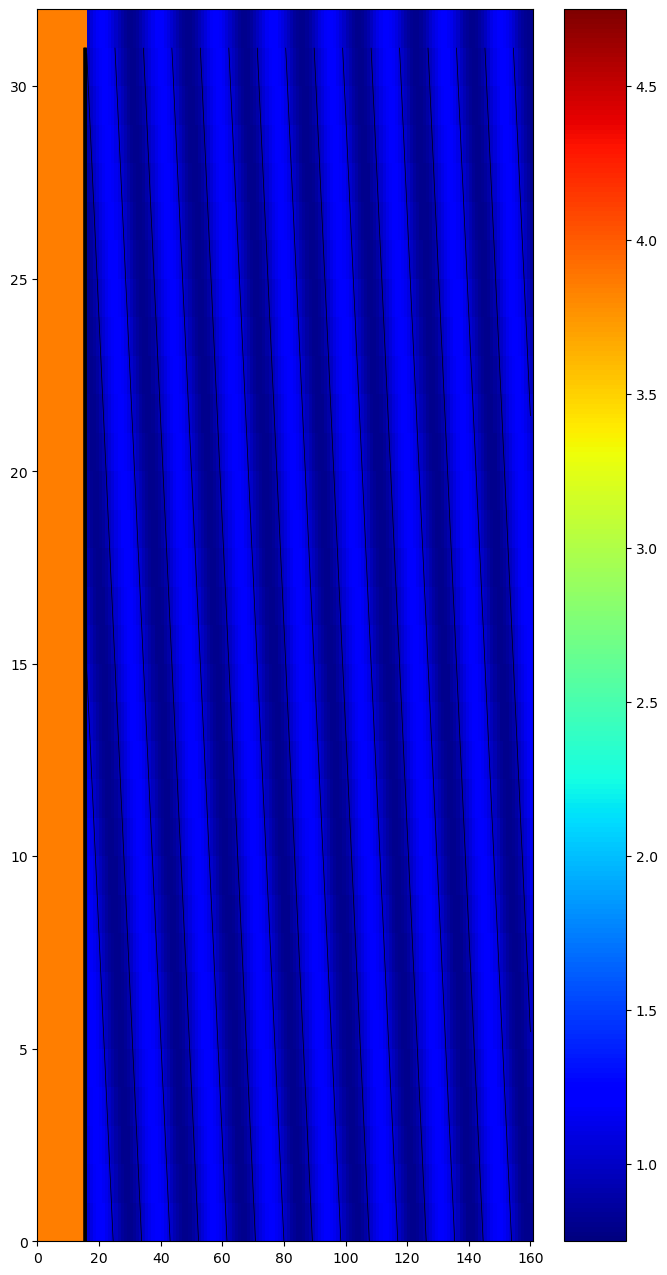

PyObject <matplotlib.contour.QuadContourSet object at 0x000000007118AD00>

In [7]:
figure(figsize=(8,16))
U=GhostPointsX(U0)

ref_U=U0[:,:,1]
a=PyPlot.pcolormesh(ref_U',cmap="jet",vmin=0.75,vmax=4.75)
PyPlot.colorbar(a)
PyPlot.contour(ref_U',levels=15,vmin=0.75,vmax=4.75,colors="black",linewidths=0.5)
#PyPlot.savefig("WENO-Z-Julia-Shock_density2D.png")

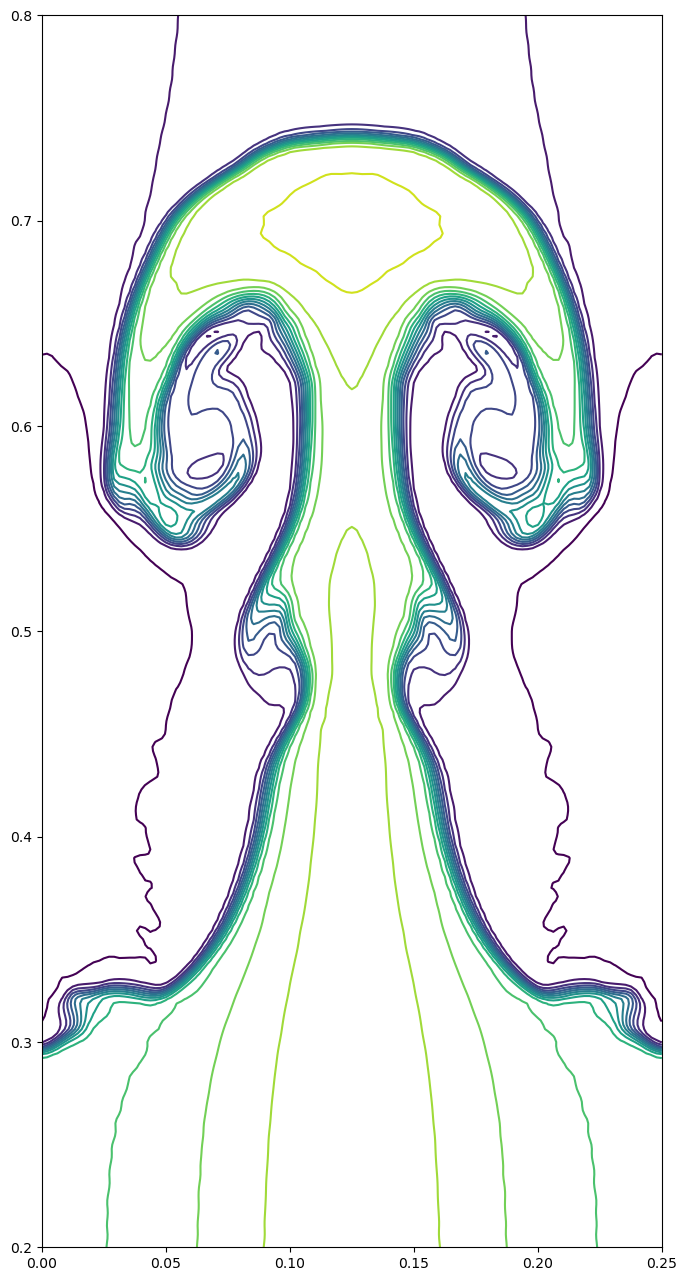

In [41]:
using PyPlot

figure(figsize=(8,16))
ref_U=U[:,:,1]
PyPlot.contour(x',y',ref_U',levels=15,vmin=0.9,vmax=2.3)
ylim(ymin=0.2,ymax=0.8)
show()

In [26]:
using PyPlot
plot(contour(
    x=x[:,1],
    y=y[1,:],
    z=U[:,:,1]',
    size = (1600,800),
    aspect_ratio=1
))

data: [
  "contour with fields aspect, size, transpose, type, x, y, and z"
]

layout: "layout with fields margin and template"

In [16]:
x[:,1]

41-element Vector{Float64}:
 0.0
 0.00625
 0.0125
 0.01875
 0.025
 0.03125
 0.0375
 0.04375
 0.05
 0.05625
 0.0625
 0.06875
 0.075
 ⋮
 0.18125
 0.1875
 0.19375
 0.2
 0.20625
 0.2125
 0.21875
 0.225
 0.23125
 0.2375
 0.24375
 0.25